In [18]:
import pandas as pd
import numpy as np

from sklearn.ensemble import RandomForestRegressor
from sklearn.preprocessing import LabelEncoder
from sklearn.preprocessing import Normalizer
from sklearn.cross_validation import cross_val_score
from sklearn.preprocessing import Imputer

from scipy.stats import skew

import seaborn as sns
import matplotlib.pyplot as plt
%matplotlib inline

plt.style.use('ggplot')

df_train = pd.read_csv("train.csv")
df_test = pd.read_csv("test.csv")

In [19]:
def is_outlier(points, thresh = 3.5):
    if len(points.shape) == 1:
        points = points[:,None]
    median = np.median(points, axis=0)
    diff = np.sum((points - median)**2, axis=-1)
    diff = np.sqrt(diff)
    med_abs_deviation = np.median(diff)

    modified_z_score = 0.6745 * diff / med_abs_deviation

    return modified_z_score > thresh

In [20]:
target = df_train[df_train.columns.values[-1]]
target_log = np.log(target)

In [21]:
df_train = df_train[df_train.columns.values[:-1]]
df = df_train.append(df_test, ignore_index = True)

In [22]:
cats = []
for col in df.columns.values:
    if df[col].dtype == 'object':
        cats.append(col)

In [23]:
df_cont = df.drop(cats, axis=1)
df_cat = df[cats]

In [24]:
for col in df_cont.columns.values:
    if np.sum(df_cont[col].isnull()) > 50:
        df_cont = df_cont.drop(col, axis = 1)
    elif np.sum(df_cont[col].isnull()) > 0:
        median = df_cont[col].median()
        idx = np.where(df_cont[col].isnull())[0]
        df_cont[col].iloc[idx] = median

        outliers = np.where(is_outlier(df_cont[col]))
        df_cont[col].iloc[outliers] = median
        
        if skew(df_cont[col]) > 0.75:
            df_cont[col] = np.log(df_cont[col])
            df_cont[col] = df_cont[col].apply(lambda x: 0 if x == -np.inf else x)
        
        df_cont[col] = Normalizer().fit_transform(df_cont[col].reshape(1,-1))[0]

/Users/jianghanyu/anaconda/lib/python2.7/site-packages/ipykernel/__main__.py:9: RuntimeWarning: divide by zero encountered in divide
/Users/jianghanyu/anaconda/lib/python2.7/site-packages/ipykernel/__main__.py:9: RuntimeWarning: invalid value encountered in divide
/Users/jianghanyu/anaconda/lib/python2.7/site-packages/ipykernel/__main__.py:11: RuntimeWarning: invalid value encountered in greater
/Users/jianghanyu/anaconda/lib/python2.7/site-packages/ipykernel/__main__.py:16: FutureWarning: reshape is deprecated and will raise in a subsequent release. Please use .values.reshape(...) instead
/Users/jianghanyu/anaconda/lib/python2.7/site-packages/ipykernel/__main__.py:13: RuntimeWarning: divide by zero encountered in log


In [25]:
for col in df_cat.columns.values:
    if np.sum(df_cat[col].isnull()) > 50:
        df_cat = df_cat.drop(col, axis = 1)
        continue
    elif np.sum(df_cat[col].isnull()) > 0:
        df_cat[col] = df_cat[col].fillna('MIA')
        
    df_cat[col] = LabelEncoder().fit_transform(df_cat[col])
    
    num_cols = df_cat[col].max()
    for i in range(num_cols):
        col_name = col + '_' + str(i)
        df_cat[col_name] = df_cat[col].apply(lambda x: 1 if x == i else 0)
        
    df_cat = df_cat.drop(col, axis = 1)

/Users/jianghanyu/anaconda/lib/python2.7/site-packages/ipykernel/__main__.py:6: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
/Users/jianghanyu/anaconda/lib/python2.7/site-packages/ipykernel/__main__.py:8: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
/Users/jianghanyu/anaconda/lib/python2.7/site-packages/ipykernel/__main__.py:13: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/panda

In [26]:
df_new = df_cont.join(df_cat)

In [27]:
array_new = np.array(df_new)

In [28]:
array_new

array([[  1.00000000e+00,   6.00000000e+01,   8.45000000e+03, ...,
          0.00000000e+00,   0.00000000e+00,   1.00000000e+00],
       [  2.00000000e+00,   2.00000000e+01,   9.60000000e+03, ...,
          0.00000000e+00,   0.00000000e+00,   1.00000000e+00],
       [  3.00000000e+00,   6.00000000e+01,   1.12500000e+04, ...,
          0.00000000e+00,   0.00000000e+00,   1.00000000e+00],
       ..., 
       [  2.91700000e+03,   2.00000000e+01,   2.00000000e+04, ...,
          0.00000000e+00,   0.00000000e+00,   0.00000000e+00],
       [  2.91800000e+03,   8.50000000e+01,   1.04410000e+04, ...,
          0.00000000e+00,   0.00000000e+00,   1.00000000e+00],
       [  2.91900000e+03,   6.00000000e+01,   9.62700000e+03, ...,
          0.00000000e+00,   0.00000000e+00,   1.00000000e+00]])

In [29]:
from sklearn.decomposition import PCA
pca = PCA(n_components=60)
pca.fit(array_new)
array_new = pca.transform(array_new)

In [30]:
# Split train and test set
X_train = df_new.iloc[:len(df_train)]
y_train = target_log

X_test = df_new.iloc[len(df_train):]

In [31]:
import xgboost as xgb
regr = xgb.XGBRegressor(
                 colsample_bytree=0.2,
                 gamma=0.0,
                 learning_rate=0.01,
                 max_depth=5,
                 min_child_weight=1.5,
                 n_estimators=7000,                                                                  
                 reg_alpha=0.9,
                 reg_lambda=0.6,
                 subsample=0.2,
                 seed=42,
                 silent=1)

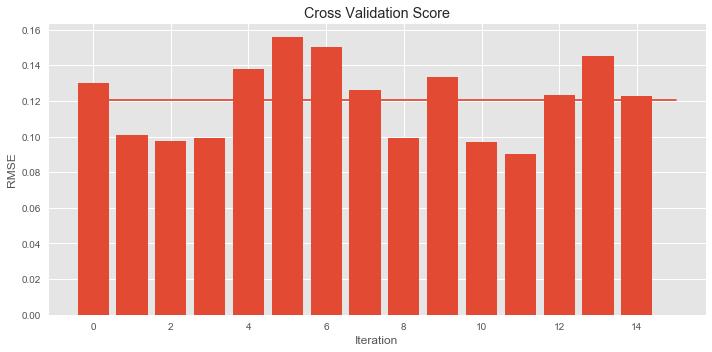

In [32]:
from sklearn.metrics import make_scorer, mean_squared_error
scorer = make_scorer(mean_squared_error, False)
cv_score = np.sqrt(-cross_val_score(estimator=regr, X=X_train, y=y_train, cv=15, scoring = scorer))

plt.figure(figsize=(10,5))
plt.bar(range(len(cv_score)), cv_score)
plt.title('Cross Validation Score')
plt.ylabel('RMSE')
plt.xlabel('Iteration')

plt.plot(range(len(cv_score) + 1), [cv_score.mean()] * (len(cv_score) + 1))
plt.tight_layout()

In [33]:
# When n_component=50, cv_score.mean()=0.1205
# When n_component=60, cv_score.mean()=0.1205
cv_score.mean()

0.12052163363668915

In [34]:
regr.fit(X_train, y_train)
# Run prediction on the Kaggle test set.
y_pred_xgb = regr.predict(X_test)
y_pred_xgb = np.exp(y_pred_xgb)
# Submission
sub = pd.DataFrame()
sub['Id'] = df_test["Id"]
sub['SalePrice'] = y_pred_xgb
sub.to_csv('submission_PCA.csv',index=False)